In [4]:
%matplotlib inline

import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from sklift.models import ClassTransformation
from sklift.models import TwoModels

from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

__1. Скачать набор данных маркетинговых кампаний__

__2. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду.__

In [5]:
df = pd.read_csv('data.csv')
df.loc[df['offer'] == 'No Offer', 'offer'] = 0
df.loc[df['offer'] != 0, 'offer'] = 1
df.rename(columns={'conversion': 'target', 'offer': 'treatment'}, inplace=True)
df['treatment'] = pd.to_numeric(df['treatment'])

df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


__3. Cделать разбиение набора данных не тренировочную и тестовую выборки__

In [6]:
indices = df.index
indices_train, indices_test = train_test_split(df.index, test_size=0.3, random_state=42)

In [7]:
X_train = df.loc[indices_train, :]
y_train = df.loc[indices_train, 'target']
treat_train = df.loc[indices_train, 'treatment']

X_test = df.loc[indices_test, :]
y_test = df.loc[indices_test, 'target']
treat_test=  df.loc[indices_test, 'treatment']

X_train_full = df.loc[indices_train, :]
y_train_full = df.loc[:, 'target']
treat_train_full = df.loc[:, 'treatment']

cat_features = ['zip_code', 'channel']

models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': [],
    'uplift@30%': []
}

__4. Сделать feature engineering__

In [8]:
df.dtypes

recency            int64
history          float64
used_discount      int64
used_bogo          int64
zip_code          object
is_referral        int64
channel           object
treatment          int64
target             int64
dtype: object

In [9]:
df.corr()

,recency,history,used_discount,used_bogo,is_referral,treatment,target
recency,1.000000,-0.246591,-0.031336,-0.026617,-0.052106,0.002828,-0.074765
history,-0.246591,1.000000,0.112677,0.114685,0.223279,0.003318,0.065153
used_discount,-0.031336,0.112677,1.000000,-0.816943,0.020900,-0.003115,0.006712
used_bogo,-0.026617,0.114685,-0.816943,1.000000,0.021346,0.002953,0.051999
is_referral,-0.052106,0.223279,0.020900,0.021346,1.000000,0.000394,-0.073924
treatment,0.002828,0.003318,-0.003115,0.002953,0.000394,1.000000,0.081073
target,-0.074765,0.065153,0.006712,0.051999,-0.073924,0.081073,1.000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   treatment      64000 non-null  int64  
 8   target         64000 non-null  int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 4.4+ MB


In [11]:
df_num_features = df.select_dtypes(include=['float64', 'int64'])
df_num_features.describe()

,recency,history,used_discount,used_bogo,is_referral,treatment,target
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.667094,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.471257,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
df_obj_features = df.select_dtypes(include='object')
df_obj_features.head()

,zip_code,channel
0,Surburban,Phone
1,Rural,Web
2,Surburban,Web
3,Rural,Web
4,Urban,Web


In [13]:
df['channel'].value_counts()

Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64

In [14]:
df['zip_code'].value_counts()

Surburban    28776
Urban        25661
Rural         9563
Name: zip_code, dtype: int64

In [15]:
len(df) - df.count()

recency          0
history          0
used_discount    0
used_bogo        0
zip_code         0
is_referral      0
channel          0
treatment        0
target           0
dtype: int64

__Нет пропущенных значений, есть высокая обратная корреляция между used_discount и used_bogo__

__5. Провести uplift-моделирование__

In [16]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)
sm_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)
models_results['uplift@30%'].append(sm_score_30)

In [17]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)
ct_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)
models_results['uplift@30%'].append(ct_score_30)

In [18]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)
tm_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)
models_results['uplift@30%'].append(tm_score_30)

__6. Вывести единую таблицу сравнения метрик__

In [19]:
pd.DataFrame(data=models_results)

,approach,uplift@10%,uplift@20%,uplift@30%
0,SoloModel,0.0,0.329759,0.219928
1,ClassTransformation,1.0,0.842600,0.561733
2,TwoModels,0.0,0.329759,0.219928


__7. Построить модель UpliftTreeClassifier__

In [23]:
X_train_tree = pd.concat([X_train.drop('zip_code', 1), 
                          pd.get_dummies(X_train['zip_code'], prefix='zip_code')], 1)

X_train_tree = pd.concat([X_train.drop('channel', 1), 
                          pd.get_dummies(X_train['channel'], prefix='channel')], 1)

features = [col for col in X_train_tree]

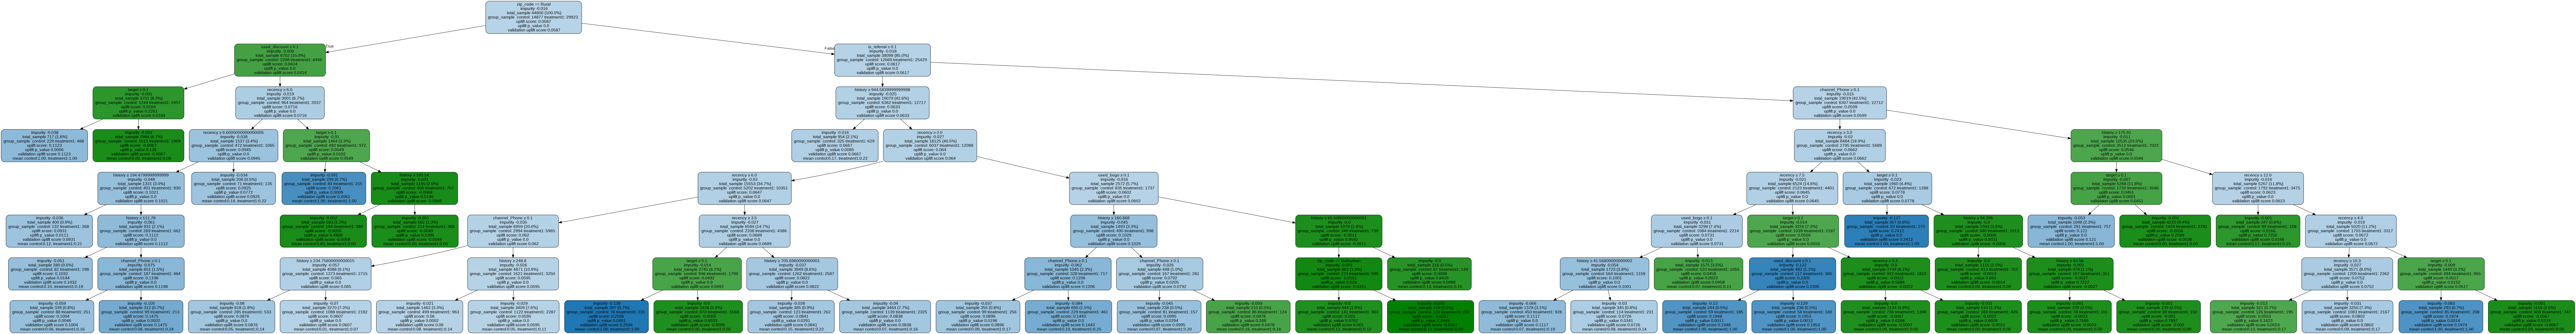

In [24]:
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())